# Exploratory Data Analysis

## EDA Summary

- The dataset is composed of 5 object classes, all well-represented in train/val/test splits.
- Class 2 is less frequent across all subsets, which may lead to class imbalance during training.
- All bounding boxes follow the YOLO format with normalized coordinates.
- All images in the dataset have a fixed resolution of *416×416 pixels*

### Object-Level Analysis

- **Object Size** (width × height):  
  Classes vary significantly in bounding box dimensions. This suggests that anchor-based models may need tuning to better fit small vs large objects.

- **Aspect Ratio (width / height):**  
  The aspect ratio distribution is right-skewed, with the majority of values between 0.3 and 2.0. This suggests that most objects are narrower than they are tall, though there are also elongated horizontal boxes with aspect ratios exceeding 5. The variation in shape across objects supports the use of diverse anchor shapes or consideration of anchor-free architectures.

### Practical Takeaways

- Perform anchor box tuning, using bounding box clustering (e.g., k-means) to identify optimal anchor sizes and aspect ratios.
- Account for the fact that anchor boxes are shared across classes — variation in object dimensions may reduce matching accuracy if not properly modeled.
- If the variation in object shape and size is too high for effective anchor design, consider using anchor-free detectors such as DETR or CenterNet.

### Conclusion

This exploratory analysis revealed consistent and meaningful patterns in object size and shape distributions across all dataset splits. These insights will directly inform the selection of model architecture, anchor configurations, preprocessing strategies, and evaluation plans, enabling a more robust and tailored training process.

In [1]:
# Import libraries
from pathlib import Path
from collections import Counter

import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Raw data file infos
- Image file name: *009000_jpg.rf.8c46e1aa5b46a0ad24ee4bcb2945d22a.jpg*
- Label file name: *009000_jpg.rf.8c46e1aa5b46a0ad24ee4bcb2945d22a.txt*
- Label file content: *2 0.6538461538461539 0.5420673076923077 0.0625 0.06610576923076923*
- Label file format (YOLO): ``<class_id> <x_center> <y_center> <width> <height>``

### Train, Test, Validation dataset distribution analysis
**Dataset Split Overview**
- The dataset is divided into 3 subsets: Train/Test/Validation --> 70%/10%/20%
- This split provides a solid foundation:
    - The training set is large enough for the model to learn meaningful patterns.
    - The validation set offers stable feedback for tuning and early stopping.
    - The test set is reserved for final, unbiased model evaluation.

**Class Distribution**
- Training set: ``'4': 1427, '1': 1393, '3': 1379, '0': 1284, '2': 698``
- Test set: ``'4': 395, '0': 391, '1': 389, '3': 366, '2': 225``
- Validation set: ``'3': 203, '4': 203, '1': 193, '0': 166, '2': 118``
- The dataset is generally well-distributed and suitable for training a deep learning model, with exception for class 2.
    - Class 2 has the lowest number of instances across all subsets, especially in the training set (698 vs. 1400+ for others). This imbalance may affect model performance, particularly its ability to detect class 2.
    - Some mitigation strategies that can be applied: Class-weighted loss functions; Data augmentation; Oversampling the class.


In [6]:
def count_class_instances(label_dir: Path):
    """Method to count class instances. Return: Counter({'class': number of instances of the class, ...})"""
    class_counts = Counter()
    
    for label_file in label_dir.glob('*.txt'):
        with open(label_file, 'r') as f:
            for line in f:
                class_id = line.strip().split()[0]
                class_counts[class_id] += 1
    
    return class_counts

#### Visualize number of class instances in Train, Test, Validation datasets

In [7]:
test_instances = count_class_instances(Path('/home/leticia/projetos/AI-Porfolio/computer-vision-anomaly-detection/data/raw/test/labels'))
train_instances = count_class_instances(Path('/home/leticia/projetos/AI-Porfolio/computer-vision-anomaly-detection/data/raw/train/labels'))
valid_instances = count_class_instances(Path('/home/leticia/projetos/AI-Porfolio/computer-vision-anomaly-detection/data/raw/valid/labels'))

print(f'Train instances: {train_instances}\nTest instances: {test_instances}\nValidation instances: {valid_instances}')

Train instances: Counter({'4': 1427, '1': 1393, '3': 1379, '0': 1284, '2': 698})
Test instances: Counter({'3': 203, '4': 203, '1': 193, '0': 166, '2': 118})
Validation instances: Counter({'4': 395, '0': 391, '1': 389, '3': 366, '2': 225})


#### Visualize Train/Test/Validation distribuition

In [8]:
# Total number of instances
total = sum(train_instances.values()) + sum(test_instances.values()) + sum(valid_instances.values())

# Compute percentage distribution
train_pct = (sum(train_instances.values()) / total) * 100
test_pct = (sum(test_instances.values()) / total) * 100
valid_pct = (sum(valid_instances.values()) / total) * 100

print(f"Train/Test/Validation distribution: "
      f"{train_pct:.2f}% / {test_pct:.2f}% / {valid_pct:.2f}%")

Train/Test/Validation distribution: 70.00% / 10.00% / 20.00%


#### Visualize class distribution

In [9]:
def counter_to_df(counter, split_name):
    """Convert Counters to DataFrames."""
    df = pd.DataFrame(counter.items(), columns=["class_id", "count"])
    df["split"] = split_name
    df["class_id"] = df["class_id"].astype(int)
    return df

df_train = counter_to_df(train_instances, "Train")
df_valid = counter_to_df(valid_instances, "Validation")
df_test  = counter_to_df(test_instances, "Test")

# Combine all DataFrames
df_all = pd.concat([df_train, df_valid, df_test])

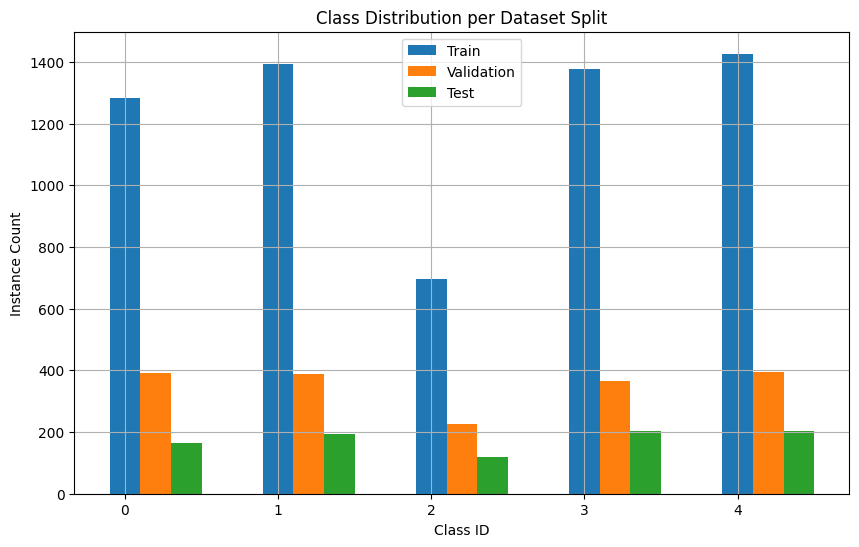

In [6]:
# Plot class distribution
plt.figure(figsize=(10, 6))
for split in df_all["split"].unique():
    subset = df_all[df_all["split"] == split]
    plt.bar(subset["class_id"] + 0.2 * ["Train", "Validation", "Test"].index(split), 
            subset["count"], width=0.2, label=split)

plt.xticks(sorted(df_all["class_id"].unique()))
plt.xlabel("Class ID")
plt.ylabel("Instance Count")
plt.title("Class Distribution per Dataset Split")
plt.legend()
plt.grid(True)
plt.show()

### Image visualization with bouding boxes

In [15]:
def load_yolo_labels(label_path):
    """
    Parses a YOLO-format label file.
    Returns a list of (class_id, x_center, y_center, width, height).
    """
    boxes = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            coords = list(map(float, parts[1:]))
            boxes.append((class_id, *coords))
    return boxes

def draw_yolo_boxes(image_path, label_path):
    """
    Draws YOLO bounding boxes on the image.
    """
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Gets the height (h) and width (w) of the image — used to scale the normalized YOLO coordinates to pixel coordinates.
    h, w, _ = image.shape

    boxes = load_yolo_labels(label_path)

    for class_id, x_c, y_c, box_w, box_h in boxes:
        # Converts normalized YOLO format values (which are in [0, 1]) to pixel coordinates:
        x1 = int((x_c - box_w / 2) * w)
        y1 = int((y_c - box_h / 2) * h)
        x2 = int((x_c + box_w / 2) * w)
        y2 = int((y_c + box_h / 2) * h)

        # Draw rectangle
        color = (0, 255, 0)
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

    # Show image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Image with {len(boxes)} bounding box")
    plt.show()

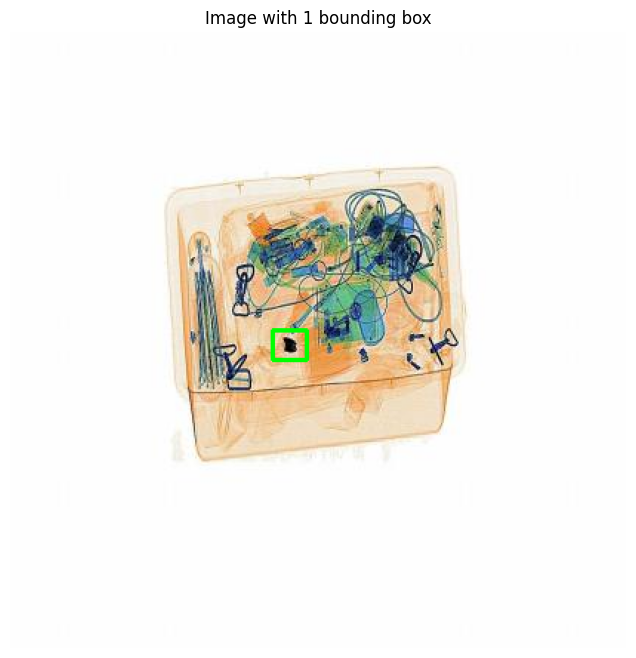

In [16]:
image_path = Path('/home/leticia/projetos/AI-Porfolio/computer-vision-anomaly-detection/data/raw/train/images/009033_jpg.rf.ad55c0cc506839afffac6d009ce1f111.jpg')
label_path = Path('/home/leticia/projetos/AI-Porfolio/computer-vision-anomaly-detection/data/raw/train/labels/009033_jpg.rf.ad55c0cc506839afffac6d009ce1f111.txt')

draw_yolo_boxes(image_path, label_path)

### Bounding Box Analysis

In [19]:
def extract_box_stats(label_dir: Path):
    """
    Extracts width, height, and aspect ratio from YOLO-format labels. Return: Tuple of three lists (widths, heights, aspect_ratios)
    """
    widths, heights, aspect_ratios = [], [], []

    for txt_file in label_dir.glob("*.txt"):
        with open(txt_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    _, _, _, box_w, box_h = map(float, parts)
                    widths.append(box_w)
                    heights.append(box_h)
                    aspect_ratios.append(box_w / box_h)

    return widths, heights, aspect_ratios

In [ ]:
train_labels = Path('/home/leticia/projetos/AI-Porfolio/computer-vision-anomaly-detection/data/raw/train/labels')
val_labels = Path('/home/leticia/projetos/AI-Porfolio/computer-vision-anomaly-detection/data/raw/valid/labels')
test_labels = Path('/home/leticia/projetos/AI-Porfolio/computer-vision-anomaly-detection/data/raw/test/labels')

train_w, train_h, train_ar = extract_box_stats(train_labels)
val_w, val_h, val_ar = extract_box_stats(val_labels)
test_w, test_h, test_ar = extract_box_stats(test_labels)

#### Bouding Box Width Distribution
- Most bounding boxes across all splits (train, validation, test) have normalized widths between 0.05 and 0.10, indicating that objects in the dataset tend to be narrow.
- The distributions are right-skewed, with a long tail extending up to ~0.30 — meaning there are a few rare, wide objects.
- The shapes of the distributions are consistent across all dataset splits, which confirms that the data split was well-balanced and representative.

Implications:
- Anchor-based models (e.g., YOLO, Faster R-CNN) should include anchor boxes that cover small to moderately wide objects.
- Including anchors in the range of ~0.05, ~0.10, and ~0.20–0.25 is recommended.

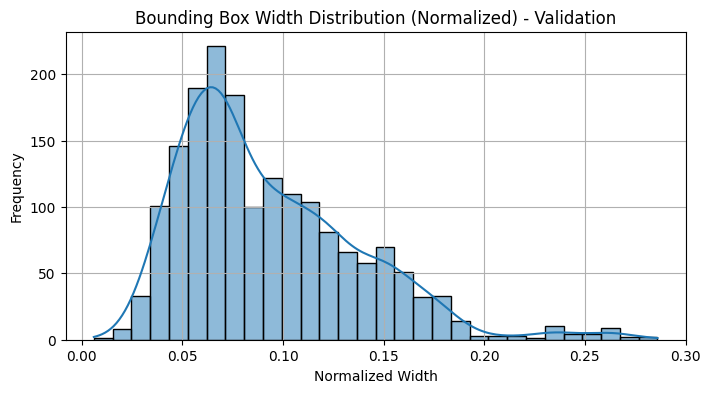

In [27]:
plt.figure(figsize=(8, 4))
sns.histplot(val_w, kde=True, bins=30)
plt.title("Bounding Box Width Distribution (Normalized) - Validation")
plt.xlabel("Normalized Width")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

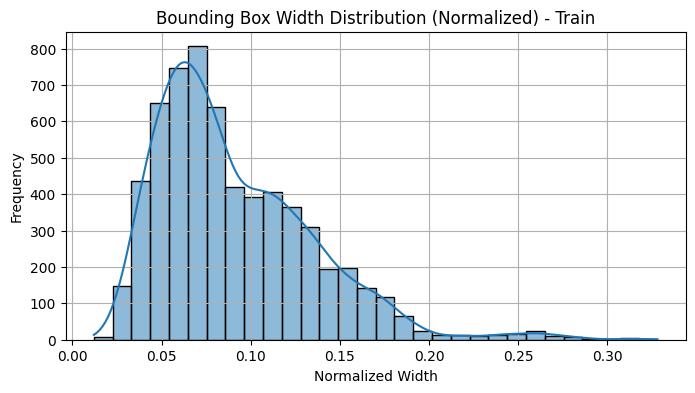

In [28]:
plt.figure(figsize=(8, 4))
sns.histplot(train_w, kde=True, bins=30)
plt.title("Bounding Box Width Distribution (Normalized) - Train")
plt.xlabel("Normalized Width")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

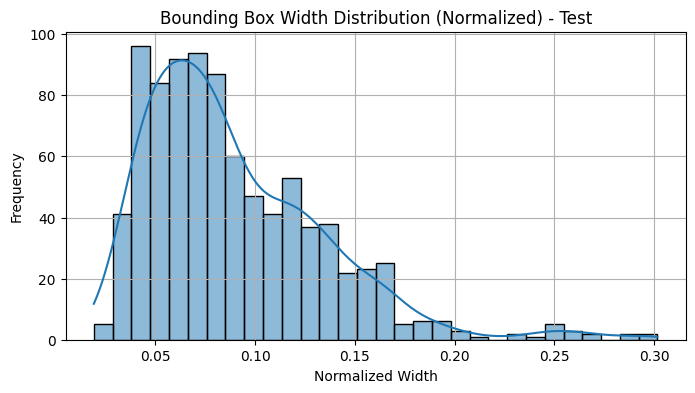

In [29]:
plt.figure(figsize=(8, 4))
sns.histplot(test_w, kde=True, bins=30)
plt.title("Bounding Box Width Distribution (Normalized) - Test")
plt.xlabel("Normalized Width")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

#### Bouding Box Aspect Ratio Distribution
- The aspect ratio distribution (width/height) is right-skewed across all dataset splits, with most values falling between 0.3 and 2.0. This indicates that objects in the dataset tend to be narrower than they are tall, but there is significant variability. Some bounding boxes exhibit high aspect ratios (up to 6–7), representing elongated objects.
- The consistency of the distribution across train, validation, and test sets ensures that the model will generalize well across different object shapes. For anchor-based models, this analysis supports the inclusion of diverse anchor shapes such as 0.5, 1.0, 2.0, and 3.0 to handle both compact and elongated objects.
- If using an anchor-free model, it's needed that the model to generalize across a wide variety of shapes, which it should be able to handle

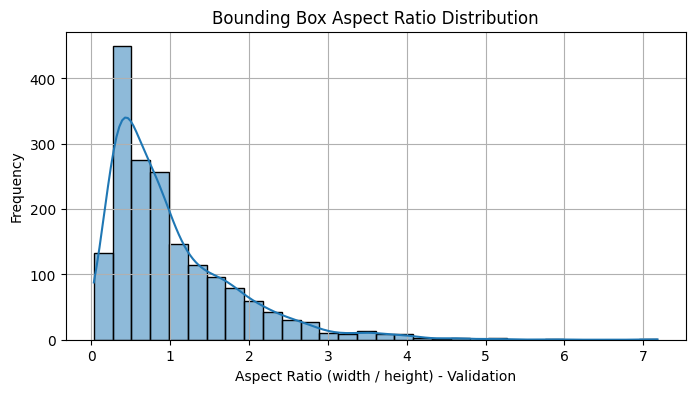

In [30]:
plt.figure(figsize=(8, 4))
sns.histplot(val_ar, kde=True, bins=30)
plt.title("Bounding Box Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (width / height) - Validation")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

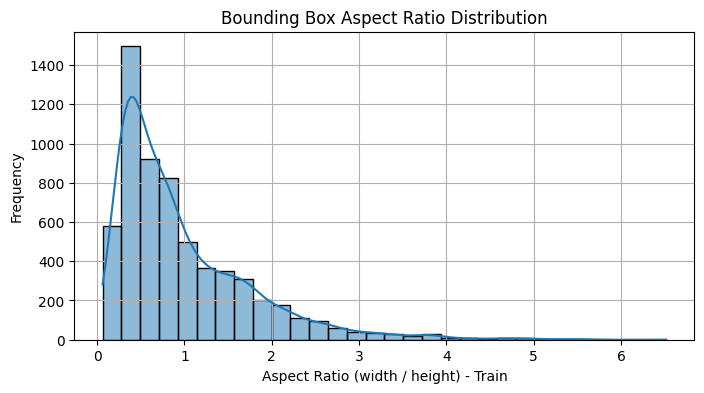

In [31]:
plt.figure(figsize=(8, 4))
sns.histplot(train_ar, kde=True, bins=30)
plt.title("Bounding Box Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (width / height) - Train")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

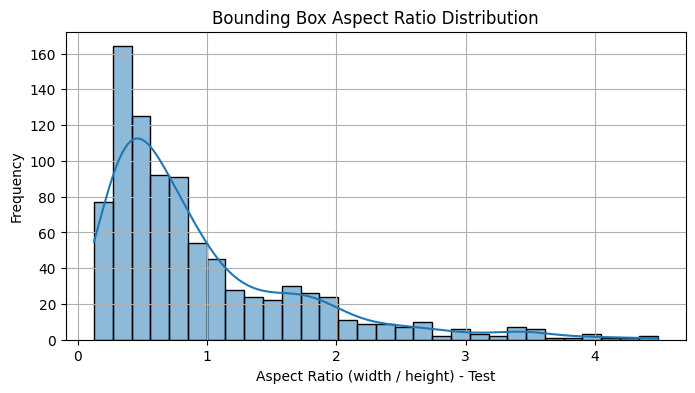

In [32]:
plt.figure(figsize=(8, 4))
sns.histplot(test_ar, kde=True, bins=30)
plt.title("Bounding Box Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (width / height) - Test")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Image Dimensions Analysis
- All images in the dataset have a fixed resolution of *416×416 pixels*

In [5]:
def get_image_dimensions(image_dir: Path):
    """Get images dimensions (height, width)."""
    dimensions = []
    for img_path in image_dir.glob(f"*.jpg"):
        img = cv2.imread(str(img_path))
        if img is not None:
            h, w = img.shape[:2]
            dimensions.append((w, h))
    return dimensions

In [8]:
train_dim = get_image_dimensions(Path('/home/leticia/projetos/AI-Porfolio/computer-vision-anomaly-detection/data/raw/train/images'))
test_dim = get_image_dimensions(Path('/home/leticia/projetos/AI-Porfolio/computer-vision-anomaly-detection/data/raw/test/images'))
val_dim = get_image_dimensions(Path('/home/leticia/projetos/AI-Porfolio/computer-vision-anomaly-detection/data/raw/valid/images'))

In [11]:
# Get unique dimensions
print(f'Train - Image width, height {sorted(set(train_dim))}')
print(f'Test - Image width, height {sorted(set(test_dim))}')
print(f'Validation - Image width, height {sorted(set(val_dim))}')

Train - Image width, height [(416, 416)]
Test - Image width, height [(416, 416)]
Validation - Image width, height [(416, 416)]
